##### Copyright 2020 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title ##### Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Single Column MNIST Classification

In this colab, we experiment with classification of the traditional MNIST dataset, but in the presence of multimodal uncertainty.  We accomplish this by degrading the input signal:  Feeding the model only the central column from the input image.  By doing so, we cause certain output labels (e.g. 5, 8, 3) to have inputs which appear nearly identical.  We also demonstrate how to model this data using Variational Inference with mixture distributions for the posterior.  This colab mirrors one of the experiments presented in [1], in which we demonstrate that optimizing a Stratified-IWAE bound on the evidence returns a model which is better able to capture multimodal uncertainty than models which optimize a Stratified-ELBO bound.

### References

[1] Morningstar et al. (2020):  Automatic Differentiation Variational Inference with Mixtures ([arxiv preprint](https://arxiv.org/abs/2003.01687))

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/python/experimental/nn/examples/single_column_mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/experimental/nn/examples/single_column_mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


In [ ]:
import numpy as np
import functools
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
tf.enable_v2_behavior()

from tensorflow_probability.python.experimental import nn as tfn

tfb = tfp.bijectors
tfd = tfp.distributions

# Getting the data


In [ ]:
class Preprocess(object):
  def __init__(self, info):
    """Initialize the preprocessing object."""

    self.ind = info.features['image'].shape[0] // 2

  def __call__(self, inputs):
    # Normalize and center the input image
    x = 2*tf.cast(inputs['image'][..., self.ind, 0], tf.float32) / 255. -1.
    y = tf.cast(inputs['label'], tf.int32)

    return x, y

In [ ]:
tf.random.set_seed(42)
seedstream = tfp.util.SeedStream(seed=43, salt='siwae')

dataset = 'mnist'
batch_size = 32
num_epochs = 25

data, info = tfds.load(dataset, with_info=True)
preprocess_fn = Preprocess(info)

train_data, eval_data = data['train'], data['test']

train_data = tfn.util.tune_dataset(train_data,
                                   batch_size=batch_size,
                                   shuffle_size=1071,
                                   preprocess_fn=preprocess_fn,
                                   repeat_count=num_epochs)
eval_data = tfn.util.tune_dataset(eval_data,
                                  batch_size=500,
                                  preprocess_fn=preprocess_fn,
                                  repeat_count=None)

# Visualizing the data

Just to demonstrate that this data is _hard_ to classify, lets see what it looks like by showing a batch of data from the training set.

(0, 112)

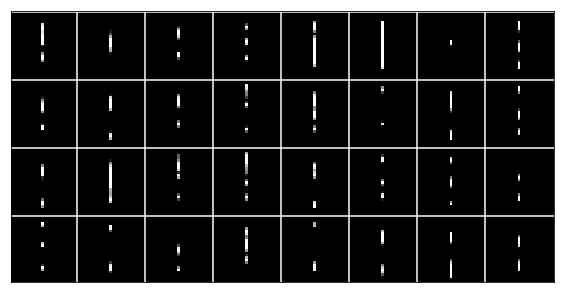

In [ ]:
def reshape_image_batch(tensor, cut=None, rows=None, axis=0):
  """Given an array of shape [n, x, y, ...] reshape it to create an image field.

  Arguments:
    tensor: The array to reshape.
    cut: Optional cut on the number of images to view. Will default to whole
      array.
    rows: Number of rows to use.  Will default to the integer less than the
      sqrt.
    axis: Axis to interpretate at the batch dimension.  By default the image
      dimensions immediately follow.

  Returns:
    reshaped_array: An array of shape [rows * x, cut / rows * y, ...]
  """
  original_shape = tensor.get_shape().as_list()
  assert len(original_shape) >= 2, 'array must be at least 3 Dimensional.'

  if cut is None:
    cut = original_shape[axis]
  if rows is None:
    rows = int(np.sqrt(cut))

  cols = cut // rows
  cut = cols * rows

  leading = original_shape[:axis]
  x_width = original_shape[axis + 1]
  y_width = original_shape[axis + 2]
  remaining = original_shape[axis + 3:]

  tensor = tensor[..., :cut, :, :, :]
  tensor = tf.reshape(tensor, leading + [rows, cols, x_width, y_width] + remaining)
  new_shape = [i for i in range(len(tensor.get_shape().as_list()))]
  new_shape[axis + 1] = axis + 2
  new_shape[axis + 2] = axis + 1
  tensor = tf.transpose(tensor, new_shape)
  tensor = tf.reshape(tensor, leading + [rows * x_width, cols * y_width] + remaining)

  return tensor

x, y = next(iter(train_data))
xim = tfb.Pad(paddings=((13, 14),), constant_values=-1.)(x[..., tf.newaxis])
plt.figure(figsize=(10, 5))
plt.imshow(reshape_image_batch(xim[..., tf.newaxis], rows=4)[:,:,0],cmap='gray')
for i in range(8):
  plt.axhline(i*28-0.5, color='w')
  plt.axvline(i*28-0.5, color='w')
plt.xticks([])
plt.yticks([])
plt.xlim(0, 8*28)
plt.ylim(0, 4*28)

In [ ]:
class Encoder(tf.Module):
  def __init__(self, input_size=28,
               num_hidden=128, 
               encoded_size=2, 
               nmix=2, 
               name=None):

    super(Encoder, self).__init__(name=name or 'encoder')

    self.input_size = input_size
    self.nmix=nmix
    self.num_hidden=num_hidden
    self.encoded_size=encoded_size

    # Convenience function
    affine = functools.partial(tfn.Affine,
                               init_kernel_fn=tf.initializers.he_normal(),
                               init_bias_fn = tf.zeros_initializer())

    self._dnn = tfn.Sequential([
        affine(self.input_size, self.num_hidden), tf.nn.elu,
        affine(self.num_hidden, self.num_hidden), tf.nn.elu,
        affine(self.num_hidden, self.num_hidden), tf.nn.elu,
        affine(self.num_hidden, self.num_hidden),
        affine(self.num_hidden, self.num_out)])

  def __call__(self, inputs):
    outputs = self._dnn(inputs)

    loc_bijector = tfb.Reshape([self.nmix, self.encoded_size])
    scale_bijector = tfb.FillScaleTriL()(
        tfb.Reshape([self.nmix,self.encoded_size*(self.encoded_size+1)//2]))

    return tfd.MixtureSameFamily(
        tfd.Categorical(outputs[..., :self.nmix]),
        tfd.MultivariateNormalTriL(
            loc=loc_bijector(
                outputs[..., self.nmix:self.nmix*(1+self.encoded_size)]),
            scale_tril=scale_bijector(
                outputs[..., self.nmix*(1+self.encoded_size):])))

  @property
  def num_out(self):
    return self.nmix*(1 + self.encoded_size +
                      self.encoded_size * (self.encoded_size + 1) // 2)


In [ ]:
class Decoder(tf.Module):
  def __init__(self, encoded_size=2, num_classes=10, name=None):
    super(Decoder, self).__init__(name=name or 'decoder')

    self.encoded_size = 2
    self.num_classes = 10

    # Convenience function
    affine = functools.partial(tfn.Affine, 
                               init_kernel_fn=tf.initializers.he_normal(),
                               init_bias_fn = tf.zeros_initializer())

    # DNN is just an affine transformation for the decoder
    self._dnn = affine(self.encoded_size, self.num_classes)

  def __call__(self, inputs):
    return tfd.Categorical(logits=self._dnn(inputs))

In [ ]:
class Vae(tf.Module):
  def __init__(self, encoder, decoder, prior, nz, beta=1.0, seed=None):
    self.encoder = encoder
    self.decoder = decoder
    self.prior = prior
    self.nz = nz
    self.beta = beta
    self.seed=seed

  def __call__(self, x, y):

    # Surrogate posterior
    pzgx = self.encoder(x)

    # Posterior component weights
    mix_logits = pzgx.mixture_distribution.logits_parameter()  # [n, k]

    # Posterior samples
    z = pzgx.components_distribution.sample(self.nz,
                                            seed=self.seed)  # [t, n, k, d]

    # Likelihood distribution
    pygz = self.decoder(z)

    # log p(y|z)
    lpygz = pygz.log_prob(y[..., tf.newaxis])  # [t, n, k]

    # log q(z|x), which requires two annoying transposes
    transpose_second_and_third_dims = lambda x: tf.transpose(
        x, tf.concat([[0, 2, 1], tf.range(3, tf.rank(x))], axis=0))

    lqzgx = transpose_second_and_third_dims(
        pzgx.log_prob(transpose_second_and_third_dims(z)))  # [t, n, k]

    # log r(z)
    lrz = self.prior.log_prob(z)  # [t, n, k]

    return lpygz, lqzgx, lrz, mix_logits

class Selbo(Vae):
  def __call__(self, x, y):

    # Get everything you need from the base class
    lpygz, lqzgx, lrz, mix_logits = super(Selbo, self).__call__(x, y)
    alpha = tf.math.softmax(mix_logits, axis=-1)

    # for housekeeping, lets place this in terms of nll and kld
    K = tf.cast(tf.shape(alpha)[-1], tf.float32)
    nll = -tf.reduce_mean(lpygz * alpha, axis=[0, 1, 2]) * K
    kl = tf.reduce_mean((lqzgx - lrz) * alpha, axis=[0, 1, 2]) * K

    return nll + beta * kl, (nll, kl)

class Siwae(Vae):
  def __call__(self, x, y):
    # Get everything you need from the base class
    lpygz, lqzgx, lrz, mix_logits = super(Siwae, self).__call__(x, y)

    # Convert logits into log-probs
    log_alpha = tf.math.log_softmax(mix_logits, axis=-1)

    # For comparison to SELBO, lets gather the nll and kld
    alpha = tf.math.softmax(mix_logits, axis=-1)
    K = tf.cast(tf.shape(alpha)[-1], tf.float32)
    nll = -tf.reduce_mean(lpygz * alpha, axis=[0, 1, 2]) * K
    kl = tf.reduce_mean((lqzgx - lrz) * alpha, axis=[0, 1, 2]) * K

    # Importance weights:  shape = [t, n, k]
    wts = lpygz + self.beta * (lrz - lqzgx) + log_alpha

    # LME over samples, LSE over modes:  shape = [n]
    T = tf.cast(tf.shape(wts)[0], tf.float32)
    siwae = tf.math.reduce_logsumexp(wts, axis=[0, -1]) - tf.math.log(T)

    # SIWAE is average over data:  shape = []
    return -tf.math.reduce_mean(siwae, axis=0), (nll, kl)


# Define the model




In [ ]:
encoded_size = 2
num_hidden = 128
nmix = 10
nz = 1
beta = 0.05
lr = 0.001

# ---------------------------------------------------------------

loss_fn = Selbo(
    encoder=Encoder(input_size=info.features['image'].shape[0],
                    encoded_size=encoded_size,
                    num_hidden=num_hidden,
                    nmix=nmix),
    decoder=Decoder(encoded_size=encoded_size,
                    num_classes=info.features['label'].num_classes),
    prior=tfd.MultivariateNormalDiag(loc=tf.zeros(encoded_size),
                                     scale_diag=tf.ones(encoded_size)),
    nz=nz,
    beta=beta,
    seed=seedstream)

opt = tf.optimizers.Adam(lr)
train_op = tfn.util.make_fit_op(
    loss_fn=loss_fn, optimizer=opt,
    trainable_variables=loss_fn.trainable_variables,
    xla_compile=False)  # xla doesn't like this... not sure why

# Train the model

In [ ]:
for i, (x, y) in enumerate(iter(train_data)):
  this_loss, (this_nll, this_kl) = train_op(x, y)
  if i %5000 == 0:
    print("iteration %i,  loss:  %.4f,   nll:  %.4f,   kl:  %.4f"%(
        i, this_loss.numpy(), this_nll.numpy(), this_kl.numpy()))

# Evaluate the accuracy

In [ ]:
def evaluate_accuracy(encoder, decoder, dataset, nz=100, seed=None):
  """Evaluate the accuracy of a model on a dataset."""
  it = iter(dataset)
  hits = 0
  trials = 0

  for x, y in it:
    pzgx = encoder(x)
    z = pzgx.sample(nz, seed=seed)
    pygz = decoder(z)
    # average py over samples / components and get argmax as prediction
    avg_log_py = tfp.math.reduce_logmeanexp(
        tf.math.log_softmax(pygz.logits_parameter(), axis=-1), axis=0)
    yhat = tf.cast(tf.argmax(avg_log_py, axis=-1), tf.int32)
    hits += tf.reduce_sum(tf.cast(tf.equal(yhat, y), tf.int32))
    trials += tf.size(y)
  acc = tf.cast(hits, tf.float32)/tf.cast(trials, tf.float32)
  return acc

In [ ]:
# Evaluate predictive accuracy with 10k samples
print("accuracy:   %.4f"%(
    evaluate_accuracy(encoder=loss_fn.encoder,
                      decoder=loss_fn.decoder,
                      dataset=eval_data,
                      nz=10000).numpy(),
                      seed=seedstream))

# Comparing performance.

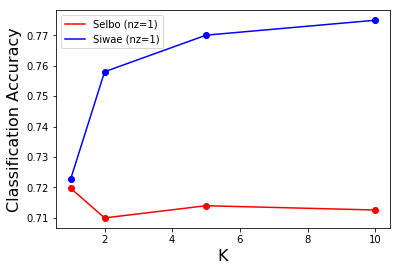

In [ ]:
encoded_size = 2
num_hidden = 128
nz = 1
beta = 0.05
lr = 0.001

K = [1, 2, 5, 10]
objectives = [Selbo, Siwae]

acc_selbo = []
acc_siwae = []

for k in K:
  for objective in objectives:
    # Setup the model
    loss_fn = objective(
        encoder=Encoder(input_size=info.features['image'].shape[0],
                        encoded_size=encoded_size,
                        num_hidden=num_hidden,
                        nmix=k),
        decoder=Decoder(encoded_size=encoded_size,
                        num_classes=info.features['label'].num_classes),
        prior=tfd.MultivariateNormalDiag(loc=tf.zeros(encoded_size),
                                        scale_diag=tf.ones(encoded_size)),
        nz=nz,
        beta=beta,
        seedstream=seedstream)

    opt = tf.optimizers.Adam(lr)
    train_op = tfn.util.make_fit_op(
        loss_fn=loss_fn, optimizer=opt,
        trainable_variables=loss_fn.trainable_variables,
        xla_compile=False)  # xla doesn't like this... not sure why

    # Train the model
    for i, (x, y) in enumerate(iter(train_data)):
      this_loss, (this_nll, this_kl) = train_op(x, y)

    if objective == Selbo:
      acc_selbo.append(evaluate_accuracy(
          encoder=loss_fn.encoder,
          decoder=loss_fn.decoder,
          dataset=eval_data,
          nz=10000,
          seed=seedstream).numpy())
    else:
      acc_siwae.append(evaluate_accuracy(
          encoder=loss_fn.encoder,
          decoder=loss_fn.decoder,
          dataset=eval_data,
          nz=10000,
          seed=seedstream).numpy())

plt.plot(K, acc_selbo, 'r-', label='Selbo (nz=1)')
plt.plot(K, acc_selbo, 'ro')
plt.plot(K, acc_siwae, 'b-', label='Siwae (nz=1)')
plt.plot(K, acc_siwae, 'bo')
plt.xlabel('K', fontsize=16)
plt.ylabel('Classification Accuracy', fontsize=16)
plt.legend()